In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random
from tqdm import tqdm

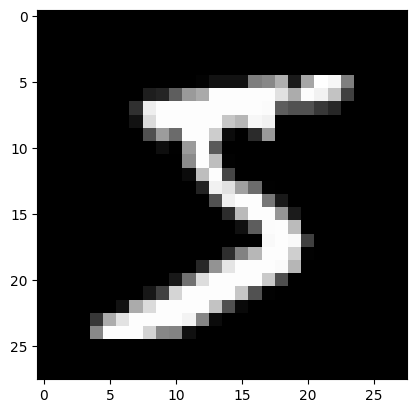

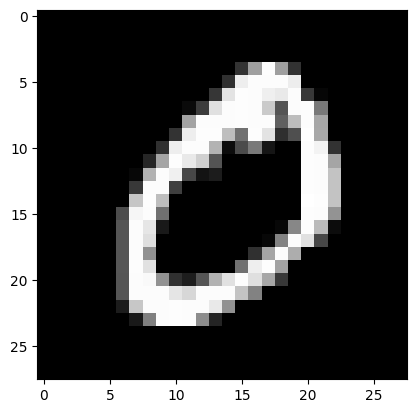

In [3]:
MNISTData = tuple[np.ndarray, np.ndarray]

def load_data() -> tuple[MNISTData, MNISTData]:
    return mnist.load_data()

(train_X, train_y), (test_X, test_y) = load_data()

for i in range(2):
    plt.imshow(train_X[i], cmap=plt.get_cmap("gray"))
    plt.show()


In [4]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
input_dim = train_X.shape[1] * train_X.shape[2]
output_dim = np.unique(train_y).size

input_dim, output_dim

(784, 10)

In [6]:
def one_hot_encode(data: np.ndarray) -> np.ndarray:
    encoded_list = np.zeros((data.size, data.max() + 1))
    encoded_list[np.arange(data.size), data] = 1

    return encoded_list


train_y = one_hot_encode(train_y)
test_y = one_hot_encode(test_y)

train_X = train_X.reshape(-1, input_dim)
test_X = test_X.reshape(-1, input_dim)

train_y.shape, test_y.shape, train_X.shape, test_X.shape

((60000, 10), (10000, 10), (60000, 784), (10000, 784))

In [691]:
def loss(y_hat: np.ndarray, y: np.ndarray) -> float:
    return np.mean((y_hat - y) ** 2)


def ReLU(x: np.ndarray):
    return np.maximum(0, x)


def ReLU_derivative(x: np.ndarray):
    return np.where(x > 0, 1, 0)


class NN:
    """
    Neural network with two hidden layers
    """

    def __init__(self, input_dim: int, output_dim: int, hidden_layer_size: int) -> None:
        limit = 1 / np.sqrt(input_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.hidden_layer_size = hidden_layer_size

        self.layer_1_weights = np.random.uniform(
            -limit, limit, size=(input_dim, self.hidden_layer_size)
        )
        self.layer_1_biases = np.zeros(self.hidden_layer_size)

        self.layer_2_weights = np.random.uniform(
            -limit, limit, size=(self.hidden_layer_size, self.hidden_layer_size)
        )
        self.layer_2_biases = np.zeros(self.hidden_layer_size)

        self.layer_3_weights = np.random.uniform(
            -limit, limit, size=(self.hidden_layer_size, output_dim)
        )
        self.layer_3_biases = np.zeros(output_dim)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Performs the forward pass of the neural network.

        Args:
            x (np.ndarray): The 1-dimensional input data of dimension input_dim

        Returns:
            np.ndarray: The output of the neural network.
        """
        assert len(x.shape) == 1
        assert x.shape[0] == self.input_dim

        out = self.layer_1_weights.T @ x + self.layer_1_biases
        out = ReLU(out)

        out = self.layer_2_weights.T @ out + self.layer_2_biases
        out = ReLU(out)

        out = self.layer_3_weights.T @ out + self.layer_3_biases
        out = ReLU(out)

        return out

    def forward_batch(
        self, mini_batch: np.ndarray[np.ndarray]
    ) -> list[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        assert mini_batch.shape[1] == self.input_dim

        z_1 = mini_batch @ self.layer_1_weights + self.layer_1_biases
        a_1 = ReLU(z_1)

        z_2 = a_1 @ self.layer_2_weights + self.layer_2_biases
        a_2 = ReLU(z_2)

        z_3 = a_2 @ self.layer_3_weights + self.layer_3_biases
        a_3 = ReLU(z_3)

        return z_1, a_1, z_2, a_2, z_3, a_3

    def evaluate_batch(self, mini_batch: list[tuple[np.ndarray, np.ndarray]]) -> int:
        expected_output = np.argmax([y for _, y in mini_batch], axis=1)

        *_, output = self.forward_batch(np.array([x for x, _ in mini_batch]))

        return np.sum(np.argmax(output, axis=1) == expected_output)

    def SGD(
        self,
        training_data: list[tuple[np.ndarray, np.ndarray]],
        epochs=5,
        learning_rate=0.001,
        mini_batch_size=100,
        test_data: list[tuple[np.ndarray, np.ndarray]] = None,
    ):
        n = len(training_data)

        for epoch in range(epochs):
            random.shuffle(training_data)

            mini_batches = [
                training_data[k : k + mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]

            for mini_batch in tqdm(mini_batches):
                self.update_mini_batch(mini_batch, learning_rate)

            if not test_data:
                continue

            test_batches = [
                test_data[k : k + mini_batch_size]
                for k in range(0, len(test_data), mini_batch_size)
            ]

            n_correct = np.sum(
                [self.evaluate_batch(test_batch) for test_batch in test_batches]
            )

            print(
                f"Epoch: {epoch}, testing accuracy: {n_correct / len(test_data) * 100:.2f}%"
            )

    def update_mini_batch(
        self, mini_batch: list[tuple[np.ndarray, np.ndarray]], learning_rate=0.001
    ):
        m = len(mini_batch)
        X = np.array([x for x, _ in mini_batch])
        y = np.array([y for _, y in mini_batch])

        # compute y and y hat for batch
        z_1, a_1, z_2, a_2, z_3, a_3 = self.forward_batch(X)

        d_z_3 = 2 * (a_3 - y) * ReLU_derivative(z_3)
        d_w_3 = 1 / m * d_z_3.T @ a_2
        d_b_3 = 1 / m * np.sum(d_z_3, axis=0)

        d_z_2 = self.layer_3_weights @ d_z_3.T * ReLU_derivative(z_2).T
        d_w_2 = 1 / m * d_z_2 @ a_1
        d_b_2 = 1 / m * np.sum(d_z_2, axis=1)

        d_z_1 = self.layer_2_weights @ d_z_2 * ReLU_derivative(z_1).T
        d_w_1 = 1 / m * d_z_1 @ X
        d_b_1 = 1 / m * np.sum(d_z_1, axis=1)

        self.layer_3_weights = self.layer_3_weights - learning_rate * d_w_3.T
        self.layer_3_biases = self.layer_3_biases - learning_rate * d_b_3

        self.layer_2_weights = self.layer_2_weights - learning_rate * d_w_2.T
        self.layer_2_biases = self.layer_2_biases - learning_rate * d_b_2

        self.layer_1_weights = self.layer_1_weights - learning_rate * d_w_1.T
        self.layer_1_biases = self.layer_1_biases - learning_rate * d_b_1


nn = NN(input_dim, output_dim, 16)
output = nn.forward(train_X[0])

nn.SGD(
    list(zip(train_X, train_y)),
    test_data=list(zip(test_X, test_y)),
    learning_rate=0.1,
    epochs=10,
)

100%|██████████| 600/600 [00:00<00:00, 707.87it/s]


Epoch: 0, testing accuracy: 87.26%


100%|██████████| 600/600 [00:00<00:00, 861.62it/s] 


Epoch: 1, testing accuracy: 90.18%


100%|██████████| 600/600 [00:00<00:00, 1020.51it/s]


Epoch: 2, testing accuracy: 92.18%


100%|██████████| 600/600 [00:00<00:00, 1173.64it/s]


Epoch: 3, testing accuracy: 92.79%


100%|██████████| 600/600 [00:00<00:00, 825.02it/s]


Epoch: 4, testing accuracy: 93.82%


100%|██████████| 600/600 [00:00<00:00, 1064.08it/s]


Epoch: 5, testing accuracy: 94.13%


100%|██████████| 600/600 [00:00<00:00, 1224.49it/s]


Epoch: 6, testing accuracy: 94.10%


100%|██████████| 600/600 [00:00<00:00, 936.47it/s] 


Epoch: 7, testing accuracy: 94.36%


100%|██████████| 600/600 [00:00<00:00, 1027.43it/s]


Epoch: 8, testing accuracy: 94.69%


100%|██████████| 600/600 [00:00<00:00, 858.36it/s] 


Epoch: 9, testing accuracy: 95.23%


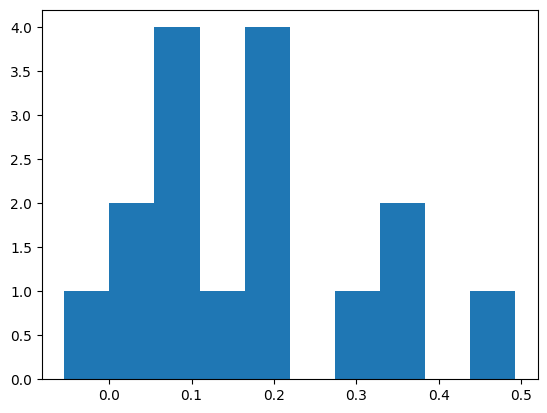

In [692]:
plt.hist(nn.layer_1_biases)
plt.show()

[0.         0.         0.         0.         0.         0.90907317
 0.         0.         0.         0.        ]


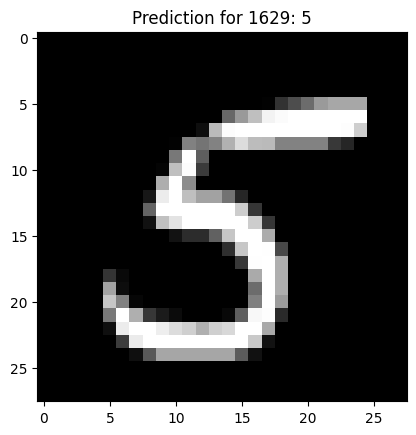

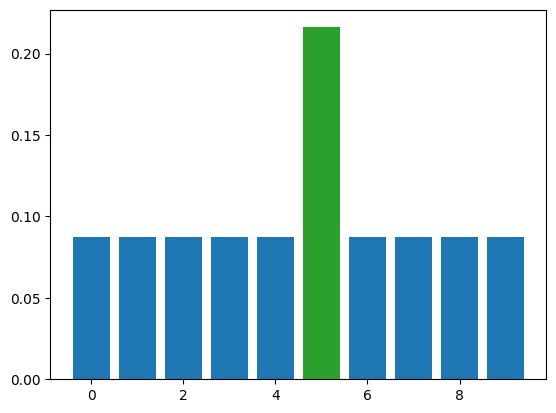

In [696]:
def softmax(x):
    e_x = np.exp(x - np.max(x))

    return e_x / e_x.sum(axis=0)


index = random.randint(0, len(test_X))

model_output = nn.forward(test_X[index])

print(model_output)

predicted_label = np.argmax(model_output)

plt.imshow(test_X[index].reshape(28, -1), cmap=plt.get_cmap("gray"))
plt.title(f"Prediction for {index}: {predicted_label}")
plt.show()

colors = ['tab:blue'] * 10
colors[np.argmax(test_y[index])] = 'tab:green'

plt.bar(np.arange(10), softmax(model_output), color=colors)
plt.show()

In [698]:
mini_batch = [
    # nothing
    # (np.array([0, 0, 0, 0]), np.array([0, 0, 0, 0])),
    # (np.array([1, 0, 0, 0]), np.array([0, 0, 0, 0])),
    # (np.array([0, 1, 0, 0]), np.array([0, 0, 0, 0])),
    # (np.array([0, 0, 1, 0]), np.array([0, 0, 0, 0])),
    # (np.array([0, 0, 0, 1]), np.array([0, 0, 0, 0])),
    # solid
    (np.array([0.5, 0.5, 0.5, 0.5]), np.array([1, 0, 0, 0])),
    (np.array([0.5, 1, 0.5, 0.5]), np.array([1, 0, 0, 0])),
    (np.array([0.5, 1, 1, 0.5]), np.array([1, 0, 0, 0])),
    (np.array([0.5, 1, 1, 1]), np.array([1, 0, 0, 0])),
    (np.array([1, 0.5, 0.5, 0.5]), np.array([1, 0, 0, 0])),
    (np.array([1, 1, 1, 1]), np.array([1, 0, 0, 0])),
    # vertical
    (np.array([0, 0.5, 0, 1]), np.array([0, 1, 0, 0])),
    (np.array([0, 1, 0, 1]), np.array([0, 1, 0, 0])),
    (np.array([0, 1, 0, 0.5]), np.array([0, 1, 0, 0])),
    (np.array([0, 0.5, 0, 0.5]), np.array([0, 1, 0, 0])),
    (np.array([0.5, 0, 1, 0]), np.array([0, 1, 0, 0])),
    (np.array([1, 0, 1, 0]), np.array([0, 1, 0, 0])),
    (np.array([1, 0, 0.5, 0]), np.array([0, 1, 0, 0])),
    (np.array([0.5, 0, 0.5, 0]), np.array([0, 1, 0, 0])),
    # diagonal
    (np.array([0.5, 0, 0, 0.5]), np.array([0, 0, 1, 0])),
    (np.array([1, 0, 0, 0.5]), np.array([0, 0, 1, 0])),
    (np.array([0.5, 0, 0, 1]), np.array([0, 0, 1, 0])),
    (np.array([1, 0, 0, 1]), np.array([0, 0, 1, 0])),
    (np.array([0, 1, 1, 0]), np.array([0, 0, 1, 0])),
    (np.array([0, 0.5, 1, 0]), np.array([0, 0, 1, 0])),
    (np.array([0, 1, 0.5, 0]), np.array([0, 0, 1, 0])),
    (np.array([0, 0.5, 0.5, 0]), np.array([0, 0, 1, 0])),
    # horizontal
    (np.array([0, 0, 0.5, 0.5]), np.array([0, 0, 0, 1])),
    (np.array([0, 0, 0.5, 0.5]), np.array([0, 0, 0, 1])),
    (np.array([0, 0, 1, 1]), np.array([0, 0, 0, 1])),
    (np.array([0, 0, 0.5, 1]), np.array([0, 0, 0, 1])),
    (np.array([0, 0, 1, 0.5]), np.array([0, 0, 0, 1])),
    (np.array([1, 1, 0, 0]), np.array([0, 0, 0, 1])),
    (np.array([0.5, 0.5, 0, 0]), np.array([0, 0, 0, 1])),
    (np.array([0.5, 1, 0, 0]), np.array([0, 0, 0, 1])),
    (np.array([1, 0.5, 0, 0]), np.array([0, 0, 0, 1])),
]

nn = NN(4, 4, 20)

output = nn.forward_batch(np.array([x for x, y in mini_batch]))

nn.SGD(
    mini_batch,
    test_data=mini_batch,
    learning_rate=0.1,
    epochs=200,
)



100%|██████████| 1/1 [00:00<00:00, 1222.47it/s]


Epoch: 0, testing accuracy: 25.81%


100%|██████████| 1/1 [00:00<00:00, 2702.52it/s]


Epoch: 1, testing accuracy: 29.03%


100%|██████████| 1/1 [00:00<00:00, 2174.34it/s]


Epoch: 2, testing accuracy: 35.48%


100%|██████████| 1/1 [00:00<00:00, 3634.58it/s]


Epoch: 3, testing accuracy: 35.48%


100%|██████████| 1/1 [00:00<00:00, 3934.62it/s]


Epoch: 4, testing accuracy: 45.16%


100%|██████████| 1/1 [00:00<00:00, 2467.24it/s]


Epoch: 5, testing accuracy: 51.61%


100%|██████████| 1/1 [00:00<00:00, 4854.52it/s]


Epoch: 6, testing accuracy: 51.61%


100%|██████████| 1/1 [00:00<00:00, 4044.65it/s]


Epoch: 7, testing accuracy: 54.84%


100%|██████████| 1/1 [00:00<00:00, 3093.14it/s]


Epoch: 8, testing accuracy: 58.06%


100%|██████████| 1/1 [00:00<00:00, 3134.76it/s]


Epoch: 9, testing accuracy: 58.06%


100%|██████████| 1/1 [00:00<00:00, 3066.01it/s]


Epoch: 10, testing accuracy: 67.74%


100%|██████████| 1/1 [00:00<00:00, 4485.89it/s]


Epoch: 11, testing accuracy: 67.74%


100%|██████████| 1/1 [00:00<00:00, 4447.83it/s]


Epoch: 12, testing accuracy: 67.74%


100%|██████████| 1/1 [00:00<00:00, 4144.57it/s]


Epoch: 13, testing accuracy: 70.97%


100%|██████████| 1/1 [00:00<00:00, 3134.76it/s]


Epoch: 14, testing accuracy: 70.97%


100%|██████████| 1/1 [00:00<00:00, 3039.35it/s]


Epoch: 15, testing accuracy: 70.97%


100%|██████████| 1/1 [00:00<00:00, 4116.10it/s]


Epoch: 16, testing accuracy: 70.97%


100%|██████████| 1/1 [00:00<00:00, 4529.49it/s]


Epoch: 17, testing accuracy: 70.97%


100%|██████████| 1/1 [00:00<00:00, 2755.78it/s]


Epoch: 18, testing accuracy: 70.97%


100%|██████████| 1/1 [00:00<00:00, 2763.05it/s]


Epoch: 19, testing accuracy: 74.19%


100%|██████████| 1/1 [00:00<00:00, 4481.09it/s]


Epoch: 20, testing accuracy: 74.19%


100%|██████████| 1/1 [00:00<00:00, 3472.11it/s]


Epoch: 21, testing accuracy: 74.19%


100%|██████████| 1/1 [00:00<00:00, 5675.65it/s]


Epoch: 22, testing accuracy: 74.19%


100%|██████████| 1/1 [00:00<00:00, 4696.87it/s]


Epoch: 23, testing accuracy: 74.19%


100%|██████████| 1/1 [00:00<00:00, 2695.57it/s]


Epoch: 24, testing accuracy: 74.19%


100%|██████████| 1/1 [00:00<00:00, 7810.62it/s]


Epoch: 25, testing accuracy: 74.19%


100%|██████████| 1/1 [00:00<00:00, 6533.18it/s]


Epoch: 26, testing accuracy: 74.19%


100%|██████████| 1/1 [00:00<00:00, 4563.99it/s]


Epoch: 27, testing accuracy: 77.42%


100%|██████████| 1/1 [00:00<00:00, 3216.49it/s]


Epoch: 28, testing accuracy: 77.42%


100%|██████████| 1/1 [00:00<00:00, 3631.43it/s]


Epoch: 29, testing accuracy: 77.42%


100%|██████████| 1/1 [00:00<00:00, 4485.89it/s]


Epoch: 30, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 4911.36it/s]


Epoch: 31, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 7503.23it/s]


Epoch: 32, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 5343.06it/s]


Epoch: 33, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 5127.51it/s]


Epoch: 34, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 4696.87it/s]


Epoch: 35, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 2809.31it/s]


Epoch: 36, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 2505.56it/s]


Epoch: 37, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 2646.25it/s]


Epoch: 38, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 3204.20it/s]


Epoch: 39, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 2739.58it/s]


Epoch: 40, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 3204.20it/s]


Epoch: 41, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 6786.90it/s]


Epoch: 42, testing accuracy: 80.65%


100%|██████████| 1/1 [00:00<00:00, 6096.37it/s]


Epoch: 43, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 4485.89it/s]


Epoch: 44, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 7133.17it/s]


Epoch: 45, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 4185.93it/s]


Epoch: 46, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 5377.31it/s]


Epoch: 47, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 5577.53it/s]


Epoch: 48, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 4332.96it/s]


Epoch: 49, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 5370.43it/s]


Epoch: 50, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 9446.63it/s]


Epoch: 51, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 6335.81it/s]


Epoch: 52, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 4332.96it/s]


Epoch: 53, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 8756.38it/s]


Epoch: 54, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 5468.45it/s]


Epoch: 55, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 4447.83it/s]


Epoch: 56, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 4328.49it/s]


Epoch: 57, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 5127.51it/s]


Epoch: 58, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 10754.63it/s]


Epoch: 59, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 3153.61it/s]


Epoch: 60, testing accuracy: 83.87%


100%|██████████| 1/1 [00:00<00:00, 4310.69it/s]


Epoch: 61, testing accuracy: 87.10%


100%|██████████| 1/1 [00:00<00:00, 3830.41it/s]


Epoch: 62, testing accuracy: 93.55%


100%|██████████| 1/1 [00:00<00:00, 5592.41it/s]


Epoch: 63, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 7943.76it/s]


Epoch: 64, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 3236.35it/s]


Epoch: 65, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 5405.03it/s]


Epoch: 66, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 8905.10it/s]


Epoch: 67, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 6052.39it/s]


Epoch: 68, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 5210.32it/s]


Epoch: 69, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 6533.18it/s]


Epoch: 70, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 4315.13it/s]


Epoch: 71, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 6335.81it/s]


Epoch: 72, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 3153.61it/s]


Epoch: 73, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 5262.61it/s]


Epoch: 74, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 3344.74it/s]


Epoch: 75, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 5777.28it/s]


Epoch: 76, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 3788.89it/s]


Epoch: 77, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 6533.18it/s]


Epoch: 78, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 2882.68it/s]


Epoch: 79, testing accuracy: 96.77%


100%|██████████| 1/1 [00:00<00:00, 4899.89it/s]


Epoch: 80, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4832.15it/s]


Epoch: 81, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3744.91it/s]


Epoch: 82, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4236.67it/s]


Epoch: 83, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3718.35it/s]


Epoch: 84, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 2824.45it/s]


Epoch: 85, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5077.85it/s]


Epoch: 86, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3460.65it/s]


Epoch: 87, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4262.50it/s]


Epoch: 88, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 2801.81it/s]


Epoch: 89, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5777.28it/s]


Epoch: 90, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6482.70it/s]


Epoch: 91, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4310.69it/s]


Epoch: 92, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4975.45it/s]


Epoch: 93, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 7037.42it/s]


Epoch: 94, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4670.72it/s]


Epoch: 95, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6452.78it/s]


Epoch: 96, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4443.12it/s]


Epoch: 97, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5584.96it/s]


Epoch: 98, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4524.60it/s]


Epoch: 99, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3039.35it/s]


Epoch: 100, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5652.70it/s]


Epoch: 101, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4899.89it/s]


Epoch: 102, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5785.25it/s]


Epoch: 103, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3401.71it/s]


Epoch: 104, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5817.34it/s]


Epoch: 105, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5127.51it/s]


Epoch: 106, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 9258.95it/s]


Epoch: 107, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 8630.26it/s]


Epoch: 108, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5817.34it/s]


Epoch: 109, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3355.44it/s]


Epoch: 110, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6250.83it/s]


Epoch: 111, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3597.17it/s]


Epoch: 112, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3557.51it/s]


Epoch: 113, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6574.14it/s]


Epoch: 114, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5178.15it/s]


Epoch: 115, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 1845.27it/s]


Epoch: 116, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3344.74it/s]


Epoch: 117, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 2922.86it/s]


Epoch: 118, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6141.00it/s]


Epoch: 119, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 45.28it/s]


Epoch: 120, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 2427.26it/s]


Epoch: 121, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5949.37it/s]


Epoch: 122, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5127.51it/s]


Epoch: 123, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5555.37it/s]


Epoch: 124, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 2709.50it/s]


Epoch: 125, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3320.91it/s]


Epoch: 126, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 7449.92it/s]


Epoch: 127, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4132.32it/s]


Epoch: 128, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5489.93it/s]


Epoch: 129, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5322.72it/s]


Epoch: 130, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3097.71it/s]


Epoch: 131, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4288.65it/s]


Epoch: 132, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5184.55it/s]


Epoch: 133, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3701.95it/s]


Epoch: 134, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 2584.29it/s]


Epoch: 135, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5178.15it/s]


Epoch: 136, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4215.38it/s]


Epoch: 137, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5468.45it/s]


Epoch: 138, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 2949.58it/s]


Epoch: 139, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4364.52it/s]


Epoch: 140, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4405.78it/s]


Epoch: 141, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6204.59it/s]


Epoch: 142, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3460.65it/s]


Epoch: 143, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 2725.34it/s]


Epoch: 144, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5023.12it/s]


Epoch: 145, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5262.61it/s]


Epoch: 146, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3289.65it/s]


Epoch: 147, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5315.97it/s]


Epoch: 148, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6355.01it/s]


Epoch: 149, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 2480.37it/s]


Epoch: 150, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4293.04it/s]


Epoch: 151, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6213.78it/s]


Epoch: 152, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4804.47it/s]


Epoch: 153, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6326.25it/s]


Epoch: 154, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4013.69it/s]


Epoch: 155, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3844.46it/s]


Epoch: 156, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5236.33it/s]


Epoch: 157, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4877.10it/s]


Epoch: 158, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 7244.05it/s]


Epoch: 159, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6069.90it/s]

Epoch: 160, testing accuracy: 100.00%



100%|██████████| 1/1 [00:00<00:00, 6250.83it/s]


Epoch: 161, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3401.71it/s]


Epoch: 162, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4443.12it/s]


Epoch: 163, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3597.17it/s]


Epoch: 164, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4505.16it/s]


Epoch: 165, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 9341.43it/s]


Epoch: 166, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5592.41it/s]


Epoch: 167, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5236.33it/s]


Epoch: 168, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5433.04it/s]


Epoch: 169, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5405.03it/s]


Epoch: 170, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3423.92it/s]


Epoch: 171, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4882.78it/s]


Epoch: 172, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3679.21it/s]


Epoch: 173, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3584.88it/s]

Epoch: 174, testing accuracy: 100.00%



100%|██████████| 1/1 [00:00<00:00, 5518.82it/s]


Epoch: 175, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4100.00it/s]


Epoch: 176, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4485.89it/s]


Epoch: 177, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4544.21it/s]


Epoch: 178, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5592.41it/s]


Epoch: 179, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 8355.19it/s]


Epoch: 180, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3968.12it/s]


Epoch: 181, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 8208.03it/s]


Epoch: 182, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4718.00it/s]


Epoch: 183, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 8612.53it/s]


Epoch: 184, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5461.33it/s]


Epoch: 185, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4293.04it/s]


Epoch: 186, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6326.25it/s]


Epoch: 187, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6026.30it/s]


Epoch: 188, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5315.97it/s]


Epoch: 189, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5991.86it/s]


Epoch: 190, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4860.14it/s]


Epoch: 191, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3297.41it/s]


Epoch: 192, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4346.43it/s]


Epoch: 193, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 6297.75it/s]


Epoch: 194, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 2468.69it/s]


Epoch: 195, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 3518.71it/s]


Epoch: 196, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 2189.09it/s]


Epoch: 197, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 4675.92it/s]


Epoch: 198, testing accuracy: 100.00%


100%|██████████| 1/1 [00:00<00:00, 5461.33it/s]

Epoch: 199, testing accuracy: 100.00%


In [699]:
output = nn.forward(np.array([
    0, 1,
    0, 1,
]))

{
    0: "solid",
    1: "vertical",
    2: "diagonal",
    3: "horizontal",
}[np.argmax(output)], output

('vertical', array([0.        , 1.05296723, 0.        , 0.        ]))

In [ ]:
# playground

w_1 = np.array(
    [
        [0.79, 0.9],
        [-0.29, 0.71],
        [0.19, -0.23],
        [0.19, -0.32],
    ]
)
b_1 = np.zeros(2)
w_2 = np.array(
    [
        [0.42, -0.38],
        [0.78, -0.01],
    ]
)
b_2 = np.zeros(2)

x = np.array([0, 1, 1, 0])
y = np.array([0, 1])


z_1 = x @ w_1 + b_1
a_1 = ReLU(z_1)
z_2 = a_1 @ w_2 + b_1
# a_2 = ReLU(z_2)
a_2 = z_2


first_loss = loss(a_2, y)

print(f"{first_loss:.3f}", a_2)

print(a_1, z_2, a_2)

d_z_2 = a_2 - y
d_w_2 = d_z_2.reshape(2, 1) @ a_1.reshape(1, 2)# * ReLU_derivative(z_2).reshape(1,-1).T
d_b_2 = np.sum(d_z_2)


lr = 0.7

w_2 = w_2 - lr * d_w_2
b_2 = b_2 - lr * d_b_2


ReLU(x @ w_1 + b_1) @ w_2 + b_2, y, loss(ReLU(x @ w_1 + b_1) @ w_2 + b_2, y)

0.575 [ 0.3744 -0.0048]
[0.   0.48] [ 0.3744 -0.0048] [ 0.3744 -0.0048]


(array([0.81568   , 0.59853414]), array([0, 1]), 0.41325434796690635)